In [1]:
from IPython.display import clear_output 
!pip install dash
!pip install jupyter_dash
!pip install dash-bootstrap-components
!pip install tslearn
clear_output()

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

# For save models and dataframes
import joblib
import pickle

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from matplotlib import ticker
from matplotlib.patches import Rectangle
from jupyter_dash import JupyterDash
import dash
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px
import dash_bootstrap_components as dbc

# For preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# For training machine learning model
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# For hyper-parameter tuning
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_validate, train_test_split
from sklearn.model_selection import validation_curve

# For clustering
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
from tslearn.clustering import TimeSeriesKMeans

# For model evaluation
from sklearn.metrics import make_scorer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IS project/2_integrated_dataset/weather_meter_cleaned.csv', index_col='Time', parse_dates=True)
dataset.drop('pm10', axis=1, inplace=True)
buildingName = dataset.columns[3:]

In [5]:
dataset['year'] = [i.year for i in dataset.index]
dataset['month'] = [i.month for i in dataset.index]
dataset['day'] = [i.day for i in dataset.index]
dataset['hour'] = [i.hour for i in dataset.index]
dataset['day_of_week'] = [i.dayofweek for i in dataset.index]

dataset['semesters'] = np.nan
dataset.loc[:dt.datetime(2020, 5, 4), 'semesters'] = 1 # start
dataset.loc[dt.datetime(2020, 5, 4):dt.datetime(2020, 7, 8), 'semesters'] = 0 # end
dataset.loc[dt.datetime(2020, 7, 8):dt.datetime(2020, 11, 16), 'semesters'] = 1
dataset.loc[dt.datetime(2020, 11, 16):dt.datetime(2020, 11, 23), 'semesters'] = 0
dataset.loc[dt.datetime(2020, 11, 23):dt.datetime(2021, 4, 5), 'semesters'] = 1
dataset.loc[dt.datetime(2021, 4, 5):dt.datetime(2021, 6, 21), 'semesters'] = 0
dataset.loc[dt.datetime(2021, 6, 21):, 'semesters'] = 1
dataset = dataset.astype({'semesters': 'int64'})

dataset['business'] = np.nan
dataset['business'] = [1 if i.dayofweek in [5, 6] else 0 for i in dataset.index]
dataset = dataset[['year', 'month', 'day', 'hour', 'day_of_week', 'semesters', 'business', 
                    'pm2.5', 'temp', 'humid', 
                    'female_1', 'female_2', 'female_4','female_6', 'female_8', 
                    'male_3', 'male_4', 'male_5', 'bundit',
                    'dean_edu', 'food_indus', 'itsc_front', 'language', 'mechanical_2',
                    'old_art', 'rech_cmu', 'scb2_pailom', 'serve_techsci', 'test_animal']].copy()

## Split Train and Test

In [6]:
data_train, data_test = train_test_split(dataset, test_size=0.2, shuffle=False)

In [7]:
def rmse(y_actual, y_hat):
    return np.sqrt(np.mean((y_hat - y_actual) ** 2))

def cv_rmse(y_actual, y_hat):
    return rmse(y_hat, y_actual) * 100 / y_actual.mean()

def mae(y_actual, y_hat):
  return np.mean(np.abs(y_actual - y_hat))

def mape(y_actual, y_hat):
  return np.mean(np.abs((y_hat - y_actual) / y_actual)) * 100

custom_scores = {'rmse': make_scorer(rmse, greater_is_better=False), 
                 'cv_rmse': make_scorer(cv_rmse, greater_is_better=False),
                 'mape': make_scorer(mape, greater_is_better=False),
                 'mae': make_scorer(mae, greater_is_better=False)}

model_names = ['VAR', 'VARMA', 'SVR', 'MLP']
cv_names = ['cv1','cv2','cv3','cv4','cv5'] 
metric_names = ['rmse', 'cvrmse', 'mape', 'mae']
metrics = rmse, cv_rmse, mape, mae

yhat_path = '/content/drive/MyDrive/Colab Notebooks/IS project/y_hat'

## SVR, MLP Model Validation and Testing

In [ ]:
def baseline_svr_mlp(x_train, y_train, x_test):
  ''' 
      Input argument: 
        This function takes input (x) and output (y) to train baseline svr and mlp models
      
      Return:
          yhat of svr and mlp model (dataframe)
  '''
  # Initiate model using baseline model
  models = [Pipeline([('scaler', StandardScaler()),('svr', SVR(kernel='rbf', C=1, gamma=0.1))]),
          Pipeline([('scaler', StandardScaler()),('mlp', MLPRegressor((100,100), random_state=42, max_iter=10000))])]
  # Fitting models
  base_svr = models[0].fit(X=x_train, y=y_train)
  base_mlp = models[1].fit(X=x_train, y=y_train)
  # Forecasting
  yhat_base_svr = pd.DataFrame(base_svr.predict(x_test).reshape(-1, 1), index=x_test.index, columns=['svr'])
  yhat_base_mlp = pd.DataFrame(base_mlp.predict(x_test).reshape(-1, 1), index=x_test.index, columns=['mlp'])

  return yhat_base_svr, yhat_base_mlp

In [ ]:
print(f'Input columns: {data_train.columns[:10].values}')
for i in range(10,29):
  name = data_train.columns[i]
  tscv = TimeSeriesSplit(n_splits = 5)
  print(f'Output column: {name}')
  print('\tValidation')
  cv=0
  # Validating models
  for train_index, valid_index in tscv.split(data_train): 
    cv+=1
    yhat_svr, yhat_mlp = baseline_svr_mlp(data_train.iloc[train_index, :10],
                                          data_train.iloc[train_index, i], 
                                          data_train.iloc[valid_index, :10])
    yhat_svr.to_csv(yhat_path + f'/yhat_SVR_{name}_cv{cv}.csv')
    yhat_mlp.to_csv(yhat_path + f'/yhat_MLP_{name}_cv{cv}.csv')
  
  # Testing models
  print('\tTesting')
  yhat_svr, yhat_mlp = baseline_svr_mlp(data_train.iloc[:, :10], 
                                        data_train.iloc[:, i], 
                                        data_test.iloc[:, :10])
  yhat_svr.to_csv(yhat_path + f'/yhat_SVR_{name}_test.csv')
  yhat_mlp.to_csv(yhat_path + f'/yhat_MLP_{name}_test.csv')

## Get the Forecasted Values in Each CV and on Testing Data

In [ ]:
all_yhat = dict()
for name in buildingName:
  df_contain = dataset[[name]].copy()
  df_contain[[f'{model}_{yhat_of}' for model in model_names for yhat_of in cv_names + ['test']]] = np.nan
  for model in model_names:
    for yhat_of in cv_names + ['test']:
      df = pd.read_csv(yhat_path + f'/yhat_{model}_{name}_{yhat_of}.csv')
      if model in ['VAR', 'VARMA']:
        df_contain.loc[df['Unnamed: 0'], f'{model}_{yhat_of}'] = df[name].values
      elif model in ['SVR']:
        df_contain.loc[df['Time'], f'{model}_{yhat_of}'] = df['svr'].values
      else:
        df_contain.loc[df['Time'], f'{model}_{yhat_of}'] = df['mlp'].values
  all_yhat[name] = df_contain

with open(yhat_path + 'all_yhat.pkl', 'wb') as w:
  pickle.dump(all_yhat, w)

In [8]:
with open(yhat_path + 'all_yhat.pkl', 'rb') as r:
  all_yhat = pickle.load(r)

## Plot the Forecasted Values

In [11]:
def plotly_line_plot(data, cols, colors):
  app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
  app.layout = html.Div(
      [
      #=============== Heading Title ===============#
      html.H1('Forecasting Electricity Consumption', style={'textAlign': 'center', 'color': '#503D36','font-size': 40}),
      #=============== Dropdown Boxes ===============#
      html.Div([
                html.Div([
                          html.Label(['Building Name'],style={'font-weight': 'bold', 'text-align': 'center'}),
                          dcc.Dropdown(id='name_dropdown', options =[{'label': name, 'value': name} for name in buildingName], value='female_1', style={'width':'100%', 'text-align': 'center'})
                          ], style={'width':"40%", 'display': 'inline-block'}),
                
                html.Div([
                          html.Label(['Time Serie Cross Validation'],style={'font-weight': 'bold', 'text-align': 'center'}), 
                          dcc.Dropdown(id='cv_dropdown', options =[{'label': cv, 'value': cv} for cv in cv_names + ['test']], value='cv1', style={'width':'100%', 'text-align': 'center'})
                          ], style={'width':"40%", 'display': 'inline-block'})
                ], style={"text-align": "center"}),
      #=============== Graph ===============#
      html.Div([
                dcc.Graph(id='line-plot')
                ], style={"text-align": "center"})
      ])
  # add callback decorator
  @app.callback(Output(component_id='line-plot', component_property='figure'),
                Input(component_id='name_dropdown', component_property='value'),
                Input(component_id='cv_dropdown', component_property='value'))

  def line_plot(name, cv):
    # ============ Get last index of valid and test sets to limit plot ==============#
    last_index = dict()
    tscv = TimeSeriesSplit(n_splits = 5)
    for i, (_, test_index) in enumerate(tscv.split(data_train)):
      last_index[f'cv{i+1}']  = test_index[-1]
    last_index[f'test']  = len(dataset.index)

    # ============ Get values for plotting ==============#
    df = data[f'{name}']
    y_actual_plot = [go.Scatter(x=df.index[:last_index[f'{cv}']], y=df[name][:last_index[f'{cv}']], mode='lines', marker=dict(color=px.colors.qualitative.D3[7]), name='Actual data')]

    y_pred_plots = [go.Scatter(x=df.index, y=df[col + '_' + cv], mode='lines', marker=dict(color=color), name=col) for col, color in zip(cols, colors)]
    
    # ============ Plot ==============#
    fig = go.Figure(data=y_actual_plot + y_pred_plots)
    fig.update_layout(width=1200, height=550, xaxis_title='Time', yaxis_title='Electricity Consumption',
                        template='seaborn', legend=dict(orientation="h", yanchor="bottom", y=1.02,xanchor="right", x=1), legend_font_size=15)
    return fig

  # Run the app
  if __name__ == '__main__':
      app.run_server(mode='inline')

In [12]:
data = all_yhat
cols = ['VAR', 'VARMA', 'SVR', 'MLP']
colors = [px.colors.qualitative.D3[i] for i in [6,4,1,2]]
plotly_line_plot(data, cols, colors)

<IPython.core.display.Javascript object>

## Calculate RMSE, CV(RMSE), MAPE, MAE For Validation and Testing

In [ ]:
# Create a empty dataframe
all_scores = dict()

for metric_name, metric in zip(metric_names,metrics):
  cols = [f'{model}_{cv}' for model in model_names for cv in cv_names + ['avg', 'std', 'test']]
  df_baseline_score = pd.DataFrame(np.nan, columns=cols, index=buildingName)

  # Calculate metrics for CV, Avg and Std of CV, and Test scores
  for n in buildingName:
    df_yhat = all_yhat[f'{n}']
    y_actual = df_yhat[n]
    for m in model_names:
      for c in cv_names + ['test']:
        y_pred = df_yhat[f'{m}_{c}']
        df_baseline_score.loc[n, f'{m}_{c}'] = metric(y_actual, y_pred)
      five_cv_scores = df_baseline_score.loc[n, [f'{m}_{i}' for i in cv_names]].values
      df_baseline_score.loc[n, f'{m}_avg'] = np.mean(five_cv_scores)
      df_baseline_score.loc[n, f'{m}_std'] = np.std(five_cv_scores)

  all_scores[metric_name] = df_baseline_score

with open('/content/drive/MyDrive/Colab Notebooks/IS project/model/results' + 'all_baseline_scores.pkl', 'wb') as w:
  pickle.dump(all_scores, w)
  


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/IS project/model/results' + 'all_baseline_scores.pkl', 'rb') as r:
  all_scores = pickle.load(r)

# SRV Hyperparameter Optimizaiton

In [ ]:
def svr_tuning(X,y):
  scores = dict()
  best_param = dict()
  # Set params for large
  C = [0.001 ,0.01, 0.1, 1, 10, 100, 1000]
  gamma =[0.001, 0.01, 0.1, 1, 10, 100, 1000]
  for scale in ['large', 'medium', 'fine', 'super_fine']:
    print(scale.upper() + ' Scale GridSearch')
    print(f'C: {C} \ngamma: {gamma} \n')
    
    # Setting pipeline process
    pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf'))])
    param = {'svr__gamma':gamma, 'svr__C': C}

    # GridSearch
    tscv = TimeSeriesSplit(n_splits=5)
    best_model = GridSearchCV(pipe, param, scoring=custom_scores['rmse'], 
                              cv=tscv, verbose=False, n_jobs=-1)
    best_model.fit(X,y)

    # Record the result into dataframe
    scores[scale] = pd.DataFrame(-1 * best_model.cv_results_['mean_test_score'].reshape(len(C),len(gamma)),
                                index = C, columns = gamma)
    best_param[scale] = best_model.best_params_
    joblib.dump(best_model, f'/content/drive/MyDrive/Colab Notebooks/IS project/model/results/Tuning/new_best_model/{y.name}_best_model_{scale}.pkl')
    scores[scale].to_csv(f'/content/drive/MyDrive/Colab Notebooks/IS project/model/results/Tuning/new_rmse_score/{y.name}_rmse_score_{scale}.csv')
 
    # Update auto-tune 
    best_C = best_model.best_params_['svr__C']
    index_c = C.index(best_C)
    best_gamma = best_model.best_params_['svr__gamma']
    index_gamma = gamma.index(best_gamma)
    # If index is on the far left and right 
    if index_c == len(C)-1: 
      upper_c = np.linspace(C[index_c], C[index_c] * 1.5, 5)
    else:
      upper_c = np.linspace(C[index_c], C[index_c + 1], 5)

    if index_c == 0: 
      lower_c = np.linspace(C[index_c] * 0.9, C[index_c], 5, endpoint=False)
    else:
      lower_c = np.linspace(C[index_c - 1], C[index_c], 5, endpoint=False)

    if index_gamma == len(gamma)-1: 
      upper_gamma = np.linspace(gamma[index_gamma], gamma[index_gamma] * 1.5, 5)
    else: 
      upper_gamma = np.linspace(gamma[index_gamma], gamma[index_gamma + 1], 5)

    if index_gamma == 0: 
      lower_gamma = np.linspace(gamma[index_gamma] * 0.9, gamma[index_gamma], 5, endpoint=False)
    else: 
      lower_gamma = np.linspace(gamma[index_gamma - 1], gamma[index_gamma], 5, endpoint=False)

    C = np.around(np.concatenate([lower_c, upper_c]), 2).tolist()
    gamma = np.around(np.concatenate([lower_gamma, upper_gamma]), 6).tolist()

    print(scale.upper() + ' Scale GridSearch Results:')
    print('Best RMSE Score: ' + str(best_model.best_score_))
    print('Best Parameters: ' + '(C: '+ str(best_model.best_params_['svr__C']),'),', '(gamma: '+ str(best_model.best_params_['svr__gamma']) +')\n')

In [ ]:
print(f'Input columns: {data_train.columns[:10].values}')
for i in range(10, 29):
  print(str(i) + f' {data_train.iloc[:,i].name}')
  svr_tuning(X = data_train.iloc[:,:10], y = data_train.iloc[:,i])

## Large, Medium, Fine, Super-Fine Gridseach Tuning Results

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/IS project/model/results/Tuning/new_rmse_score/'
best_model_path = '/content/drive/MyDrive/Colab Notebooks/IS project/model/results/Tuning/new_best_model'
rmse_scale_building = dict()
best_model_building = dict()
for building in buildingName:
  for scale in ['large', 'medium', 'fine', 'super_fine']:
    rmse_scale_building[f'{building}_{scale}'] = pd.read_csv(csv_path + f'/{building}_rmse_score_{scale}.csv').set_index('Unnamed: 0')
    best_model_building[f'{building}_{scale}'] = joblib.load(best_model_path + f'/{building}_best_model_{scale}.pkl')

In [ ]:
df_best_result = []
for name in buildingName:
  best_model = best_model_building[f'{name}_super_fine']
  best_c = best_model.best_params_['svr__C']
  best_gamma = best_model.best_params_['svr__gamma']
  best_score = best_model.best_score_ * -1
  df_best_result.append(name)
  df_best_result.append(best_c)
  df_best_result.append(best_gamma)
  df_best_result.append(best_score)

df_best_result = pd.DataFrame(np.array(df_best_result).reshape(-1,4)).astype({0:'str', 1:'float32', 2:'float32', 3:'float32'})
df_best_result 

In [ ]:
#@title Default title text
def plot_rsme_heatmap(name):
  fig, axes = plt.subplots(2,2, figsize=(12, 10))
  axes = axes.flatten()
  for i, scale in enumerate(['large', 'medium', 'fine', 'super_fine']):
    df = rmse_scale_building[f'{name}_{scale}'].copy()
    min_rmse = np.asarray(df).min()
    row_min, col_min  = np.where(np.asarray(df) == min_rmse)
    sns.heatmap(df, ax=axes[i], cmap=sns.cm.rocket_r)  
    axes[i].set_xlabel('gamma', size=12)
    axes[i].set_ylabel('C', size=12)
    axes[i].set_xticklabels(df.columns, rotation=40, fontsize=12)
    axes[i].set_yticklabels(df.index, rotation=40, fontsize=12)
    axes[i].set_title(f'{scale.upper()} GridSearch\n' +
                      f'C={df.index[row_min][0]} gamma={df.columns[col_min][0]}\n' +
                      f'min RMSE:{np.round(min_rmse, 4)}', fontsize=15)
    axes[i].add_patch(Rectangle((col_min, row_min), 1, 1, edgecolor='blue', fill=False, lw=2))
  fig.suptitle(f'SVR Hyperparameter Tuning ({name})', size=22, y=1.025,fontweight='bold')
  fig.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/IS project/model/results/Tuned SVR figure/{name}.png', bbox_inches='tight')
  plt.show()

In [ ]:
for building in buildingName:
  plot_rsme_heatmap(building)

Output hidden; open in https://colab.research.google.com to view.

# SVR Hyperparameter Optimization for Cluster Centriods

In [ ]:
meters = dataset.iloc[:, 10:].copy()
# ----------------------Retrieve clustering models----------------------
df_reshape = meters.copy().T.values.reshape(len(meters.columns), -1, 1)
X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df_reshape)
model_path = '/content/drive/MyDrive/Colab Notebooks/IS project/model/k-shape/'
ks3 = KShape().from_pickle(model_path + 'kshape_3.sav')
# ----------------------Predict cluster----------------------
y_hat_cluster = ks3.predict(X)
# ----------------------Display result cluster----------------------
df_yhat_cluster = pd.DataFrame(meters.columns, columns=['name'])
df_yhat_cluster['cluster_to'] = y_hat_cluster
df_yhat_cluster['centroid'] = [f'centroid_{i}' for i in y_hat_cluster]
df_yhat_cluster.head()

,name,cluster_to,centroid
0,female_1,0,centroid_0
1,female_2,0,centroid_0
2,female_4,0,centroid_0
3,female_6,0,centroid_0
4,female_8,0,centroid_0


In [ ]:
# ---------------------- Retrieve----------------------
centriod_0 = ks3.cluster_centers_[0]
centriod_1 = ks3.cluster_centers_[1]
centriod_2 = ks3.cluster_centers_[2]
df_centriod = pd.DataFrame(centriod_0, columns=['centroid_0'])
df_centriod['centroid_1'] = centriod_1
df_centriod['centroid_2'] = centriod_2
df_centriod.head()

,centroid_0,centroid_1,centroid_2
0,0.594187,-0.705764,-1.223473
1,0.123632,-0.714788,-1.222858
2,-0.188022,-0.724360,-1.239430
3,-0.306003,-0.735774,-1.336044
4,-0.278050,-0.767946,-1.549032


In [ ]:
for i in range(2,3):
  print(str(i) + f' {df_centriod.iloc[:,i].name}')
  svr_tuning(X = data_train.iloc[:,:10], y = df_centriod.iloc[:len(data_train.index), i])

In [ ]:
for building in ['centroid_0', 'centroid_1', 'centroid_2']:
  for scale in ['large', 'medium', 'fine', 'super_fine']:
    rmse_scale_building[f'{building}_{scale}'] = pd.read_csv(csv_path + f'/{building}_rmse_score_{scale}.csv').set_index('Unnamed: 0')
    best_model_building[f'{building}_{scale}'] = joblib.load(best_model_path + f'/{building}_best_model_{scale}.pkl')

In [ ]:
def tuned_svr_model(x_train, y_train, x_test, y_centroid_train):

  # Scale X_train, X_test
  scaler_X = StandardScaler().fit(x_train)
  X_train_scaled = scaler_X.transform(x_train)
  X_test_scaled = scaler_X.transform(x_test)

  # For Descale y_hat of centroid models 
  scaler_all_data = StandardScaler().fit(dataset.loc[:, [name]])
  
  # Best model detail
  tuned_svr_model = best_model_building[f'{name}_super_fine']
  cluster_tuned_svr_model = best_model_building[f'centroid_{cluster_to}_super_fine']

  # Initiate model using best model detail above
  base_model = SVR(kernel='rbf', C=1, gamma=0.1)
  tuned_model = SVR(kernel='rbf', gamma = tuned_svr_model.best_params_['svr__gamma'],
                    C = tuned_svr_model.best_params_['svr__C'])
  cluster_tuned_model = SVR(kernel='rbf', gamma = cluster_tuned_svr_model.best_params_['svr__gamma'],
                            C = cluster_tuned_svr_model.best_params_['svr__C'])

  # Fitting models
  base_model.fit(X=X_train_scaled, y=y_train)
  tuned_model.fit(X=X_train_scaled, y=y_train)
  cluster_tuned_model.fit(X=X_train_scaled, y=y_centroid_train)

  # Forecasting
  yhat_base = base_model.predict(X_test_scaled).reshape(-1, 1)
  yhat_tuned = tuned_model.predict(X_test_scaled).reshape(-1, 1)
  yhat_centroid = cluster_tuned_model.predict(X_test_scaled).reshape(-1, 1) 
  yhat_centroid_descaled = scaler_all_data.inverse_transform(yhat_centroid)

  return yhat_base, yhat_tuned, yhat_centroid_descaled

In [ ]:
for i in range(10,29): 
  name = data_train.columns[i]
  tscv = TimeSeriesSplit(n_splits = 5)
  cluster_to = df_yhat_cluster['cluster_to'][df_yhat_cluster['name'] == name].values[0]
  print(name)
  cv=0
  for train_index, valid_index in tscv.split(data_train): 
    cv+=1
    # X_train, X_test are similar in each model fits
    X_train, y_train = data_train.iloc[train_index, :11], data_train.iloc[train_index, [i]]
    X_valid, y_valid = data_train.iloc[valid_index, :11], data_train.iloc[valid_index, [i]]
    y_train_centroid = df_centriod.iloc[train_index, cluster_to]
    
    # Fitting baseline, tuned_svr, centroid_tuned_svr
    yhat_base, yhat_tuned, yhat_centroid_descaled =  tuned_svr_model(x_train=X_train, 
                                                                    y_train=y_train, 
                                                                    x_test=X_valid, 
                                                                    y_centroid_train=y_train_centroid)
    # Record Forecasting Y
    pd.DataFrame(yhat_base, index = X_valid.index).to_csv(yhat_path + f'/yhat_base_SVR_{name}_cv{cv}.csv')
    pd.DataFrame(yhat_tuned, index = X_valid.index).to_csv(yhat_path + f'/yhat_tuned_SVR_{name}_cv{cv}.csv')
    pd.DataFrame(yhat_centroid_descaled, index = X_valid.index).to_csv(yhat_path + f'/yhat_centroid_tuned_SVR_{name}_cv{cv}.csv')


  # Fitting baseline, tuned_svr, centroid_tuned_svr

  yhat_base, yhat_tuned, yhat_centroid_descaled =  tuned_svr_model(x_train=data_train.iloc[:, :10], 
                                                                  y_train=data_train.iloc[:, i], 
                                                                  x_test=data_test.iloc[:, :10], 
                                                                  y_centroid_train=df_centriod.iloc[:len(data_train.index), cluster_to])
  pd.DataFrame(yhat_base, index = data_test.index).to_csv(yhat_path + f'/yhat_base_SVR_{name}_test.csv')
  pd.DataFrame(yhat_tuned, index = data_test.index).to_csv(yhat_path + f'/yhat_tuned_SVR_{name}_test.csv')
  pd.DataFrame(yhat_centroid_descaled, index = data_test.index).to_csv(yhat_path + f'/yhat_centroid_tuned_SVR_{name}_test.csv')

female_1
female_2
female_4
female_6
female_8
male_3
male_4
male_5
bundit
dean_edu
food_indus
itsc_front
language
mechanical_2
old_art
rech_cmu
scb2_pailom
serve_techsci
test_animal


In [ ]:
model_names = ['base_SVR', 'tuned_SVR', 'centroid_tuned_SVR']
all_yhat_tuned = dict()
for name in buildingName:
  df_contain = dataset[[name]].copy()
  df_contain[[f'{model}_{yhat_of}' for model in model_names for yhat_of in cv_names + ['test']]] = np.nan
  for model in model_names:
    for yhat_of in cv_names + ['test']:
      df = pd.read_csv(yhat_path + f'/yhat_{model}_{name}_{yhat_of}.csv')
      df_contain.loc[df['Time'], f'{model}_{yhat_of}'] = df['0'].values
    all_yhat_tuned[name] = df_contain

with open(yhat_path + 'all_tuned_yhat.pkl', 'wb') as w:
  pickle.dump(all_yhat_tuned, w)

In [13]:
with open(yhat_path + 'all_tuned_yhat.pkl', 'rb') as r:
  all_yhat_tuned = pickle.load(r)

In [14]:
data = all_yhat_tuned
cols = ['base_SVR', 'tuned_SVR', 'centroid_tuned_SVR']
colors = [px.colors.qualitative.D3[i] for i in [6,3,0]]
plotly_line_plot(data, cols, colors)

<IPython.core.display.Javascript object>

In [ ]:
# Create a empty dataframe
all_tuned_scores = dict()

for metric_name, metric in zip(metric_names,metrics):
  cols = [f'{model}_{cv}' for model in model_names for cv in cv_names + ['avg', 'std', 'test']]
  df_baseline_score = pd.DataFrame(np.nan, columns=cols, index=buildingName)

  # Calculate metrics for CV, Avg and Std of CV, and Test scores
  for n in buildingName:
    df_yhat = all_yhat_tuned[f'{n}']
    y_actual = df_yhat[n]
    for m in ['base_SVR', 'tuned_SVR', 'centroid_tuned_SVR']:
      for c in cv_names + ['test']:
        y_pred = df_yhat[f'{m}_{c}']
        df_baseline_score.loc[n, f'{m}_{c}'] = metric(y_actual, y_pred)
      five_cv_scores = df_baseline_score.loc[n, [f'{m}_{i}' for i in cv_names]].values
      df_baseline_score.loc[n, f'{m}_avg'] = np.mean(five_cv_scores)
      df_baseline_score.loc[n, f'{m}_std'] = np.std(five_cv_scores)

  all_tuned_scores[metric_name] = df_baseline_score

In [ ]:
a = all_tuned_scores['mae'][['base_SVR_avg','base_SVR_std','tuned_SVR_avg','tuned_SVR_std',
                              'centroid_tuned_SVR_avg','centroid_tuned_SVR_std',
                              'base_SVR_test','tuned_SVR_test','centroid_tuned_SVR_test']].round(2)
#a.to_scv('all_tuned_mae.csv')
a

,base_SVR_avg,base_SVR_std,tuned_SVR_avg,tuned_SVR_std,centroid_tuned_SVR_avg,centroid_tuned_SVR_std,base_SVR_test,tuned_SVR_test,centroid_tuned_SVR_test
female_1,3.32,2.13,3.41,2.17,5.08,2.03,8.08,8.42,10.89
female_2,4.35,1.34,4.60,1.35,4.63,0.97,6.00,7.78,7.25
female_4,5.04,1.83,5.08,1.71,5.34,1.82,6.26,8.39,7.13
female_6,5.96,2.85,6.05,2.72,5.46,2.83,6.84,6.56,8.40
female_8,6.16,2.63,5.92,2.17,6.46,3.06,9.04,11.06,11.90
male_3,6.68,2.75,6.46,3.00,5.59,2.31,4.81,4.87,7.25
male_4,7.07,3.00,7.60,3.58,5.29,2.61,6.78,4.54,8.94
male_5,4.89,1.72,4.62,1.23,5.51,2.23,8.05,9.75,9.56
bundit,17.55,7.33,17.31,6.85,18.15,6.15,18.27,18.28,20.19
dean_edu,18.67,8.14,18.95,8.23,20.11,6.85,22.25,20.13,22.19


In [ ]:
#@title Default title text
def valid_curve(x, y, para_name, para_range):
  cv = TimeSeriesSplit(n_splits=5)
  train_scores, test_scores = validation_curve(
      estimator=Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf'))]),
      X=x, y=y, param_name=para_name, param_range=para_range, cv=cv,
      scoring='neg_root_mean_squared_error', n_jobs=-1)
  
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.figure(figsize=(10,6))
  plt.title("Validation Curve with SVR", size=20)
  plt.ylabel("Score")
  if para_name== 'svr__gamma':
    plt.xlabel(r"$\gamma$")
  else:
    plt.xlabel(r"C")

  lw = 2
  plt.semilogx(
      para_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
  )
  plt.fill_between(
      para_range,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.2,
      color="darkorange",
      lw=lw,
  )
  plt.semilogx(
      para_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
  )
  plt.fill_between(
      para_range,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.2,
      color="navy",
      lw=lw,
  )
  plt.legend(loc="best")
  plt.show()

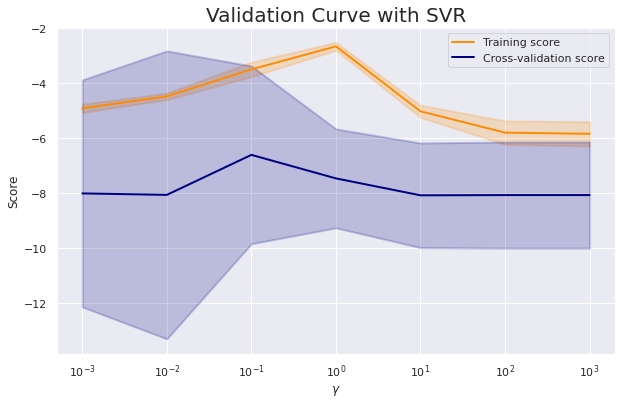

In [ ]:
x=data_train.iloc[:, :10]
y=data_train.iloc[:, 11]
para_name='svr__gamma'
para_range=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
valid_curve(x, y, para_name, para_range)

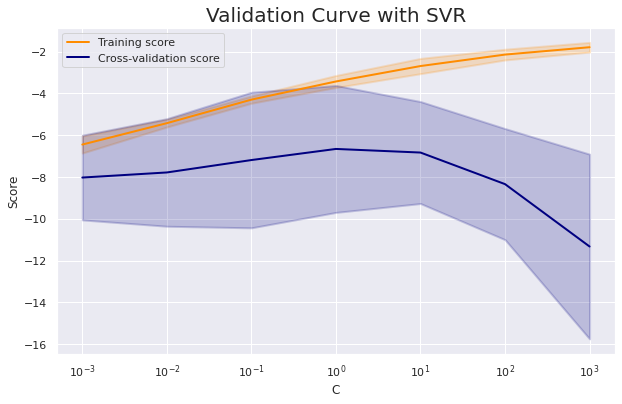

In [ ]:
x=data_train.iloc[:, :10]
y=data_train.iloc[:, 11]
para_name='svr__C'
para_range=[0.001 ,0.01, 0.1, 1, 10, 100, 1000]
valid_curve(x, y, para_name, para_range)

In [ ]:
pip install --upgrade scipy

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
w_out_cluster = -1 *best_svr_scores.iloc[:, 10].values
w_cluster = cluster_tuned_svr_scores.iloc[:, 10].values

In [ ]:
ttest_ind(a=w_cluster, b=w_out_cluster, alternative='two-sided')

Ttest_indResult(statistic=0.011256150083359643, pvalue=0.9910812299945702)